In [5]:
### Load necessary modules -------------------------------
# interactive plotting
%matplotlib inline
#%config InlineBackend.figure_format = 'svg' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# Data management libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Machine learning libraries
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# others
import math
from mltools import classification_tools as CT
from mltools import model_tools as MT
from statsmodels.stats import contingency_tables as cont_tab
from scipy.stats import binom_test
import warnings

In [6]:
df = pd.read_csv('fico.csv')
# Pasar la variable RiskPerformance a int64
df['RiskPerformance'] = df['RiskPerformance'].astype('int64')
# Put the column RiskPerformance as a category
df['RiskPerformance'] = df['RiskPerformance'].astype('category')
# Change RiskPerformance values, if they are 1 to True and if they are 0 to False
df['RiskPerformance'] = df['RiskPerformance'].replace({1: 'Yes', 0: 'No'})
df.dropna(inplace=True)
# Drop the column called NumTotalTrades
#df.drop(columns='NumTotalTrades', inplace=True)

In [7]:
# Define input and output matrices
INPUTS = ['ExternalRiskEstimate', 'NetFractionRevolvingBurden',
       'AverageMInFile', 'PercentTradesWBalance',
       'PercentInstallTrades',  "NumTotalTrades",
       'PercentTradesNeverDelq', 'MSinceMostRecentInqexcl7days']
OUTPUT = 'RiskPerformance'

X = df[INPUTS]
Y = df[OUTPUT]

# Split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=0.2,  #percentage of test data
                                                    random_state=2023, #seed for replication
                                                    stratify = Y)   #Preserves distribution of y. Same proportion. useful for classification but not for regression problemas

## Create dataset to store model predictions
dfTR_eval = X_train.copy()
dfTR_eval['RiskPerformance'] = Y_train # We will call Y as output variable for simplicity
dfTS_eval = X_test.copy()
dfTS_eval['RiskPerformance'] = Y_test # We will call Y as output variable for simplicity

In [8]:
#-------------------------------------------------------------------------------------------------
#------------------------------- RADIAL SVM MODEL ------------------------------------------------
#-------------------------------------------------------------------------------------------------
## Inputs of the model. Change accordingly to perform variable selection
INPUTS_RSVC = INPUTS
## Train model -----------------------------------------------------------------------------------
param = {'SVC__C': [0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000], # Cost term
         'SVC__gamma':[0.0001,0.001,0.01,0.1,1,10]} # Inverse width parameter in the Gaussian Radial Basis kernel. how non-linear the model "is"
pipe = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('SVC', SVC(kernel='rbf', # lineal kernel
                                   probability=True, # let the model predict probabilities
                                   random_state=150))]) # For replication

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
SVC_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='accuracy', # Accuracy https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
SVC_fit.fit(X_train[INPUTS_RSVC], Y_train) # Search in grid

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('SVC',
                                        SVC(probability=True,
                                            random_state=150))]),
             n_jobs=-1,
             param_grid={'SVC__C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                                    1000],
                         'SVC__gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
             scoring='accuracy')

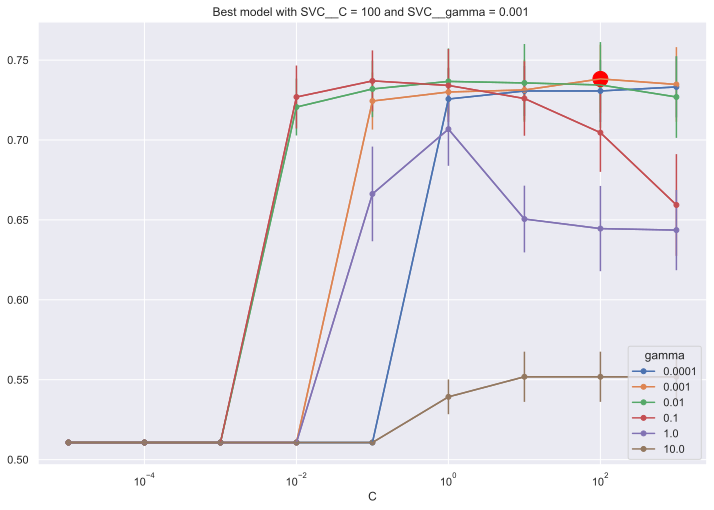

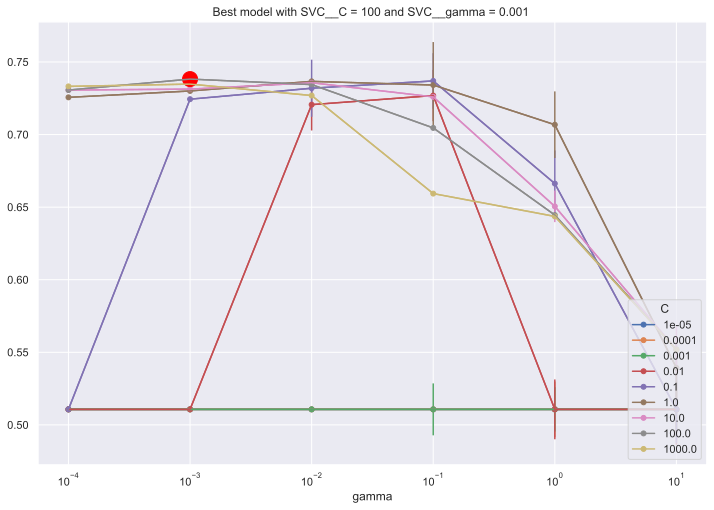

In [10]:
MT.plotModelGridError(SVC_fit, xscale="log", xscale2='log')

In [15]:
# Obtain Cross-Validation score
print("CV accuracy is")
cross_val_score(SVC_fit, X_train[INPUTS_RSVC], Y_train, cv=10, scoring='accuracy').mean()

CV accuracy is


0.734129847597642

In [11]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['Y_SVC_pred'] = SVC_fit.predict(X_train[INPUTS_RSVC])
dfTR_eval['Y_SVC_prob_neg'] = SVC_fit.predict_proba(X_train[INPUTS_RSVC])[:,0]
dfTR_eval['Y_SVC_prob_pos'] = SVC_fit.predict_proba(X_train[INPUTS_RSVC])[:,1]
### Scale test using preprocess in training
dfTS_eval['Y_SVC_pred'] = SVC_fit.predict(X_test[INPUTS_RSVC])
dfTS_eval['Y_SVC_prob_neg'] = SVC_fit.predict_proba(X_test[INPUTS_RSVC])[:,0]
dfTS_eval['Y_SVC_prob_pos'] = SVC_fit.predict_proba(X_test[INPUTS_RSVC])[:,1]

dfTR_eval.head()

,ExternalRiskEstimate,NetFractionRevolvingBurden,AverageMInFile,PercentTradesWBalance,PercentInstallTrades,NumTotalTrades,PercentTradesNeverDelq,MSinceMostRecentInqexcl7days,RiskPerformance,Y_SVC_pred,Y_SVC_prob_neg,Y_SVC_prob_pos
1605,83.0,0.0,50.0,20.0,53.0,15.0,93.0,3.0,No,No,0.685122,0.314878
524,81.0,34.0,75.0,40.0,44.0,45.0,100.0,0.0,No,No,0.752715,0.247285
2994,68.0,25.0,34.0,65.0,32.0,25.0,100.0,2.0,No,Yes,0.425613,0.574387
103,60.0,35.0,25.0,72.0,32.0,25.0,100.0,0.0,Yes,Yes,0.198539,0.801461
4112,59.0,78.0,52.0,100.0,71.0,7.0,86.0,12.0,Yes,Yes,0.158363,0.841637


In [12]:
CT.confusion_matrix(dfTR_eval['RiskPerformance'], dfTR_eval['Y_SVC_pred'], labels=['No','Yes'])

Confusion Matrix and Statistics
	   Prediction
Reference   No  Yes
       No 1118  439
      Yes  388 1237

Accuracy: 0.74
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.48
Mcnemar's Test P-Value: 0.08
Sensitivity: 0.76
Specificity: 0.72
Precision: 0.74
Recall: 0.72
Prevalence: 0.51
Detection Rate: 0.39
Detection prevalence: 0.53
Balanced accuracy: 0.74
F1 Score: 0.73
Positive label: No


In [13]:
CT.confusion_matrix(dfTS_eval['RiskPerformance'], dfTS_eval['Y_SVC_pred'], labels=['No','Yes'])

Confusion Matrix and Statistics
	   Prediction
Reference  No  Yes
       No 287  103
      Yes  94  312

Accuracy: 0.75
No Information Rate: 0.5
P-Value [Acc > NIR]: 0.0
Kappa: 0.5
Mcnemar's Test P-Value: 0.57
Sensitivity: 0.77
Specificity: 0.74
Precision: 0.75
Recall: 0.74
Prevalence: 0.51
Detection Rate: 0.39
Detection prevalence: 0.52
Balanced accuracy: 0.75
F1 Score: 0.74
Positive label: No


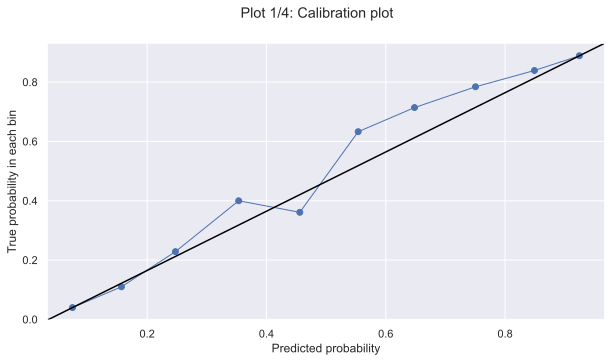

c:\Users\pablo\anaconda3\envs\ML\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


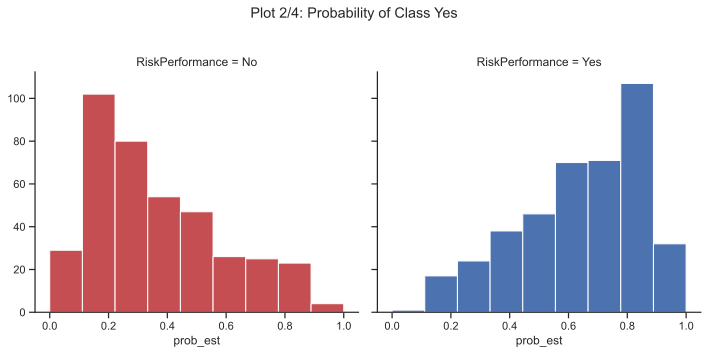

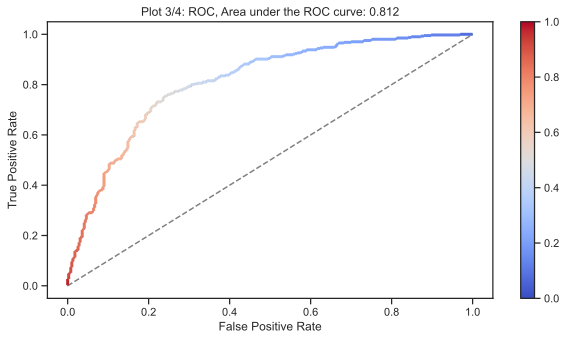

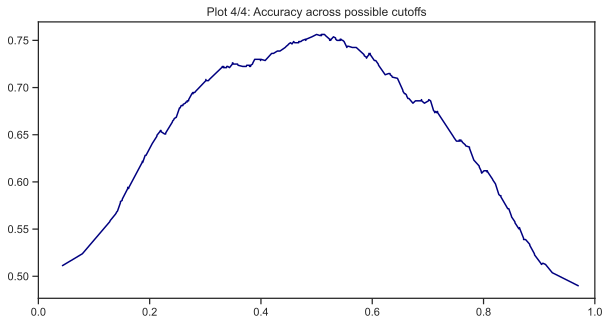

In [14]:
CT.plotClassPerformance(dfTS_eval['RiskPerformance'], SVC_fit.predict_proba(X_test), selClass='Yes')